# 라이브러리

In [ ]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt

# 사용 자료 정리

In [ ]:
# 월별 반도체 수출금액
df = pd.read_csv('/content/drive/MyDrive/데싸랩/EDA-미신검증/반도체.csv', encoding = 'cp949').set_index('산업별').T.drop(['항목', '단위', 'Unnamed: 324'])[['반도체']]
df = df.reset_index()

for i in df.index:
  df['index'].iloc[i] = df['index'].iloc[i].replace(' 월', '')


df['index'] = pd.to_datetime(df['index'])
df['year'] = df['index'].dt.year
df['month'] = df['index'].dt.month

In [ ]:
ptb = df.pivot_table(index = 'year', columns = 'month', values = '반도체')
grp_df = df.groupby('month')['반도체'].mean().reset_index()

In [ ]:
# 월별 삼성전자 주가 / 등락률
df2 = pd.read_csv('/content/drive/MyDrive/데싸랩/EDA-미신검증/삼성전자.csv',  encoding = 'cp949', parse_dates = ['일자'])
df2 = df2[['일자', '등락률']]
df2['year'] = df2['일자'].dt.year
df2['month'] = df2['일자'].dt.month
df2 = df2.groupby(['year','month'])['등락률'].sum().reset_index()

In [ ]:
# 월별 삼성전자 등락률과 반도체 수출량 및 수출 변화율
df3 = pd.merge(df, df2, left_on = ['year', 'month'], right_on = ['year', 'month'])

df3['반도체'] = df3['반도체'].astype('float')
df3['sc_change'] = np.log(df3['반도체'] / df3['반도체'].shift(1))
df3 = df3.drop(0)
df3['index'] = df3['index'].dt.strftime('%Y%m')
df3 = df3.set_index('index')
df3['date'] = list(df3.reset_index()['index'])
df3['date'] = pd.to_datetime(df3['date'], format='%Y%m')

In [ ]:
kospi = pd.read_csv('/content/drive/MyDrive/데싸랩/EDA-미신검증/kospi_data.csv', parse_dates = ['Date']).drop(['Open', 'High', 'Low','Volume'], axis = 1)
kospi['year'] = kospi['Date'].dt.year
kospi['month'] = kospi['Date'].dt.month
kospi = kospi.groupby(['year', 'month']).sum().reset_index()
start = dt.datetime(1981,5, 1)
end = dt.datetime(2022, 8, 1)
kospi['time_index'] = pd.date_range(start, end, freq = 'MS').strftime('%Y%m')
kospi = kospi.set_index('time_index', drop = True)

In [ ]:
grp_df3 = df3.groupby('month')[['반도체', '등락률']].mean().reset_index()
grp_ch = df3.groupby('month')['반도체'].mean().reset_index()
grp_scc = df3.groupby('month')['sc_change'].mean().reset_index()

In [ ]:
df3_L = df3[df3['year'] > 2005]
grp_df3_L = df3_L.groupby('month')[['반도체', '등락률']].mean().reset_index()
grp_ch_L = df3_L.groupby('month')['반도체'].mean().reset_index()
grp_scc_L = df3_L.groupby('month')['sc_change'].mean().reset_index()

In [ ]:
samkos = pd.merge(df3, kospi, left_on = ['year', 'month'], right_on = ['year', 'month'])
kos_upd = samkos.groupby('month')[['등락률']].mean().reset_index() # 삼성전자 주가 등락
kos_sc = samkos.groupby('month')['반도체'].mean().reset_index()  # 반도체 수출금액
kos_ch = samkos.groupby('month')['Change'].mean().reset_index() # 주가 등락

In [ ]:
#SK하닉 등락률과 반도체 수출 변화율 데이터
sk = pd.read_csv('/content/drive/MyDrive/데싸랩/EDA-미신검증/sk하이닉스.csv',  encoding = 'cp949', parse_dates = ['일자'])
sk = sk[['일자', '등락률']]
sk['year'] = sk['일자'].dt.year
sk['month'] = sk['일자'].dt.month
sk = sk.groupby(['year','month'])['등락률'].sum().reset_index()

sk.columns = ['year', 'month', 'sk등락률']
sk = pd.merge(sk, df3, left_on = ['year', 'month'], right_on = ['year', 'month'])
sk_L = sk[sk['year'] > 2005]

skkos = pd.merge(sk, kospi, left_on = ['year', 'month'], right_on = ['year', 'month'])

# 기업과 반도체 수출금액 변화량 상관관계 그래프

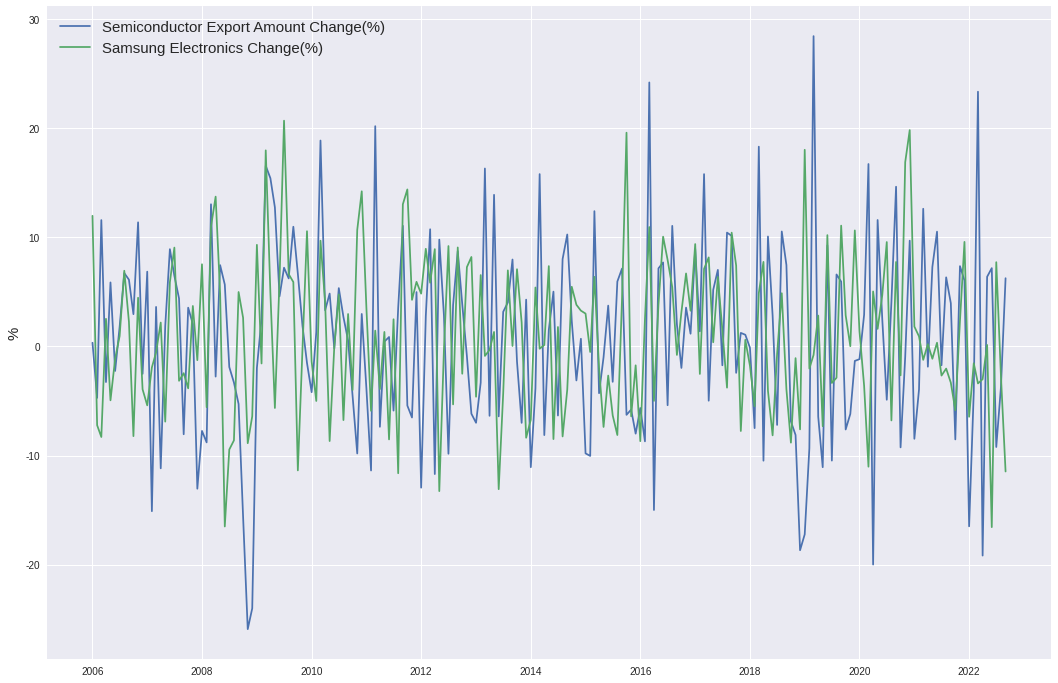

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(df3_L['date'], df3_L['sc_change']*100, label = 'Semiconductor Export Amount Change(%)')
plt.plot(df3_L['date'], df3_L['등락률'], label = 'Samsung Electronics Change(%)')
plt.legend(fontsize = 15)
plt.ylabel('%', fontsize = 15)
plt.style.use('seaborn')
plt.grid(True)
plt.show()

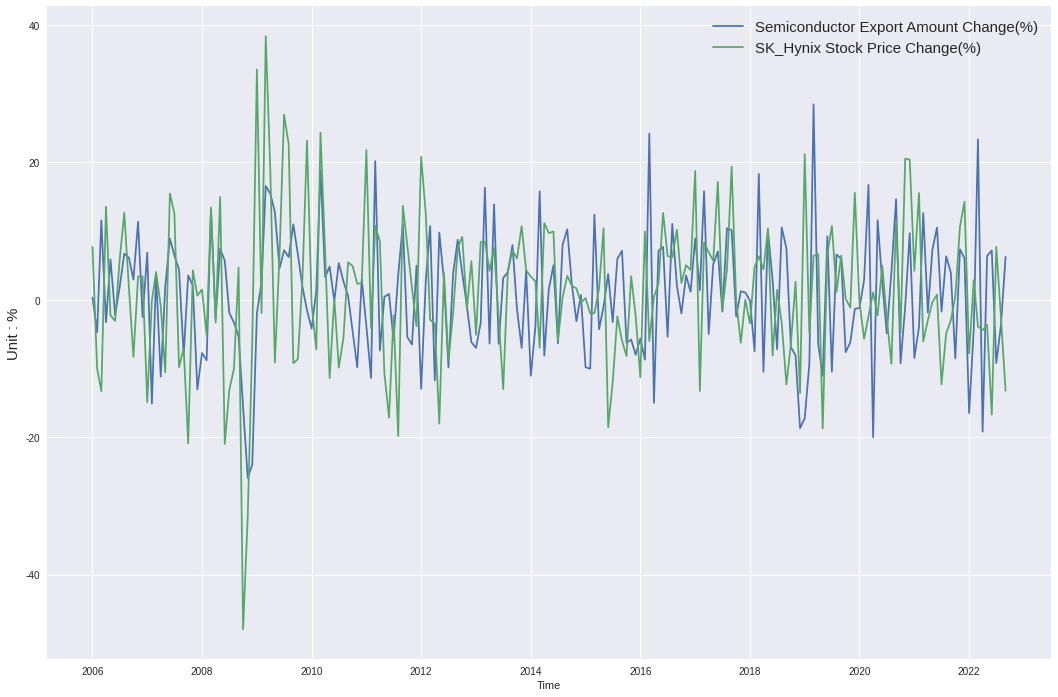

In [ ]:
#sk하이닉스 주가와 반도체 수출 변화율
plt.figure(figsize=(18,12))
plt.plot(sk_L['date'], sk_L['sc_change']*100, label = 'Semiconductor Export Amount Change(%)')
plt.plot(sk_L['date'], sk_L['sk등락률'], label = 'SK_Hynix Stock Price Change(%)')
plt.style.use('seaborn')
plt.legend(fontsize = 15)
plt.xlabel('Time')
plt.ylabel('Unit : %', fontsize = 15)

plt.grid(True)
plt.show() 

In [ ]:
print('2006년 이후 삼성전자 등락률 & 반도체 수출금액 변화율 상관관계')
print('0기간', np.corrcoef(df3_L['등락률'], df3_L['sc_change'])[0,1])
print('1기간', np.corrcoef(df3_L.reset_index(drop=True)['등락률'].shift(1).drop(0), df3_L.reset_index(drop=True)['sc_change'].drop(0))[0,1])
print('2기간', np.corrcoef(df3_L.reset_index(drop=True)['등락률'].shift(2).drop([0,1]), df3_L.reset_index(drop=True)['sc_change'].drop([0,1]))[0,1])


print('삼성전자 등락률 & 반도체 수출금액 변화율pvalue')
print('0기간', stats.pearsonr(df3_L['등락률'], df3_L['sc_change'])[1])
print('1기간', stats.pearsonr(df3_L.reset_index(drop=True)['등락률'].shift(1).drop(0), df3_L.reset_index(drop=True)['sc_change'].drop(0))[1])
print('2기간', stats.pearsonr(df3_L.reset_index(drop=True)['등락률'].shift(2).drop([0,1]), df3_L.reset_index(drop=True)['sc_change'].drop([0,1]))[1])


2006년 이후 삼성전자 등락률 & 반도체 수출금액 변화율 상관관계
0기간 0.10841553351503214
1기간 -0.029525878446982345
2기간 0.11530536417395425
삼성전자 등락률 & 반도체 수출금액 변화율pvalue
0기간 0.12552531584001225
1기간 0.6781183261233715
2기간 0.10485706045651752


In [ ]:
# 하닉 등락률 & 반도체 수출금액 <변화율> // 등락률이 선반영됨
print('2006년 이후 하닉 등락률 & 반도체 수출금액 변화율 상관관계')
print('0기간', np.corrcoef(sk_L['sk등락률'], df3_L['sc_change'])[0,1])
print('1기간', np.corrcoef(sk_L.reset_index(drop=True)['sk등락률'].shift(1).drop(0), sk_L.reset_index(drop=True)['sc_change'].drop(0))[0,1])
print('2기간', np.corrcoef(sk_L.reset_index(drop=True)['sk등락률'].shift(2).drop([0,1]), sk_L.reset_index(drop=True)['sc_change'].drop([0,1]))[0,1])

#2006년 이후 2기간 상관관계 검정
print('p.value : ', stats.pearsonr(sk_L.reset_index(drop=True)['sk등락률'].shift(2).drop([0,1]), sk_L.reset_index(drop=True)['sc_change'].drop([0,1]))[1])

2006년 이후 하닉 등락률 & 반도체 수출금액 변화율 상관관계
0기간 0.19703478221672652
1기간 0.129231663367015
2기간 0.19555485595366265
p.value :  0.0056394779479708715
